In [1]:
from phononpy import *
import matplotlib.pyplot as plt
import cupy as cp
from scipy.signal import chirp, find_peaks, peak_widths
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
GPU = True

CUDA GPU Acceleration is unavailable for your system : (


In [2]:
E = estimator(max_order=2,n_cores=10,slow=False,GPU=GPU)

Generating Estimator for order 2
Assembling the estimator using multiprocessing on 10 cores
Permuations created successfully
	Send the fast data to the pool
	Fast: 0, 0 Done!
	Fast: 1, 0 Done!
	Fast: 2, 0 Done!
	Fast: 1, 1 Done!
	Fast: 2, 1 Done!
	Fast: 2, 2 Done!
Pool closed Successfully
recasting functions


  0%|          | 0/6 [00:00<?, ?it/s]

Estimator Generated Successfully
WARNING! Since you are using GPU accelleration you need to check that your input satisfies these conditions z < v t and (z-v t)^2 > r^2 (v^2 - 1). Otherwise there will be errors


In [3]:
# Get the fast particle waves as a function of R
def get_params(r:float,v:float,T = np.array([-1.,40.]),N_pts:int=500,GPU=GPU):
    g = 1/(v**2-1)**0.5
    T = T + v * r
    z = r/g
    if GPU: t = cp.linspace(*T,N_pts)
    else:
        t = np.linspace(*T,N_pts)
    
    return r,z,t,v

In [4]:
# Calculate the Pressure for some point
r,z,t,v = get_params(2,3)
l=2e-1
p = E(r,z,t,v,l).get()

4.051203009158745 0.0017482561698303795


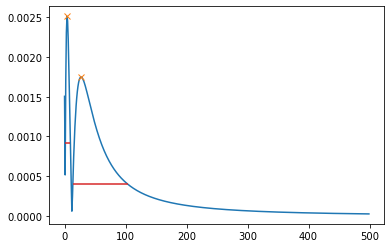

In [5]:
# Calculate the peaks and FWHM
peaks,_ = find_peaks(abs(p))
results = peak_widths(abs(p),peaks,rel_height=0.8)

# Calculate the average width
avg_width   = np.mean(results[0])*(t[1]-t[0])
peak        = np.max(p[peaks])

# Plot the stuffs
plt.plot(abs(p));
plt.hlines(*results[1:],color='C3')
plt.plot(peaks,abs(p[peaks]),"x")

# Print them
print(avg_width,peak)

In [6]:
# For a range of distances find the maximum
def sweep_r(R=np.linspace(0.1,100,100),v=3.0,l=2e-5,GPU=GPU):
    # Empty array to store the maxima over all the R's
    maxima  = []
    FWHM    = []

    # For each radius
    for rr in tqdm(R,desc='Radius GPU: '+str(GPU),leave=False):
        r,z,t,v = get_params(rr,v)
        if GPU:
            p = E(r,z,t,v,l).get()
        else:
            p = E(r,z,t,v,l)

        # Calculate the peaks and FWHM
        peaks,_ = find_peaks(abs(p))
        results = peak_widths(abs(p),peaks,rel_height=0.8)
        if len(peaks) == 0: peaks = [0]

        # Calculate the average width
        avg_width   = np.mean(results[0])*(t[1]-t[0])
        if GPU: avg_width = avg_width.get()
        peak        = np.max(p[peaks])

        # Append them to the appropriate arrays
        maxima.append(peak)
        FWHM.append(avg_width)

    return maxima,FWHM    

In [7]:
V = np.linspace(2,8,4)
R = np.linspace(0.1,100,100)

pressure_max = []
pressure_wid = []

# Now do this for a range of velocities
for v in tqdm(V,desc='Velocities'):
    MAX,WID = sweep_r(R,v)
    pressure_max.append(MAX)
    pressure_wid.append(WID)


Velocities:   0%|          | 0/4 [00:00<?, ?it/s]

Radius GPU: True:   0%|          | 0/100 [00:00<?, ?it/s]

Radius GPU: True:   0%|          | 0/100 [00:00<?, ?it/s]

Radius GPU: True:   0%|          | 0/100 [00:00<?, ?it/s]

Radius GPU: True:   0%|          | 0/100 [00:00<?, ?it/s]

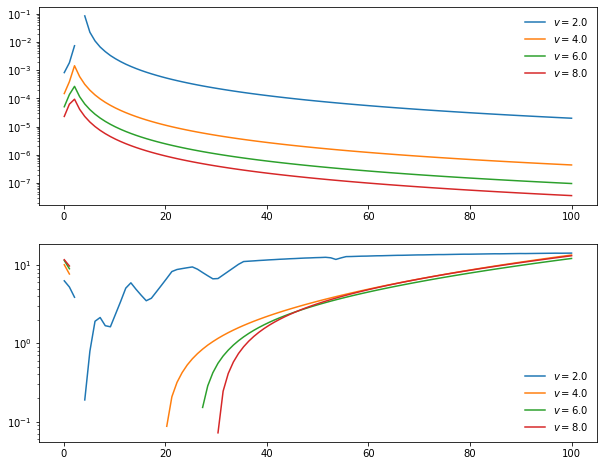

In [8]:
# Create a figure now
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# Plot all the thingys
for v,pressure,width in zip(V,pressure_max,pressure_wid):
    ax1.plot(R,pressure,label=r'$v=%.1f$'%(v))
    ax2.plot(R,width,label=r'$v=%.1f$'%(v))

# Add a legend
ax1.legend(frameon=False)
ax1.set_yscale('log')
ax2.legend(frameon=False)
ax2.set_yscale('log')